# EP2 - Conjunto de Maldelbrot e paralelização com CUDA e OMPI


## Configuração do ambiente

Atualizando os pacotes Julia

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


Verificando o status dos pacotes, e se há algum problema, com o comando:

In [2]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [336ed68f] CSV v0.7.3
  [a93c6f00] DataFrames v0.21.4
  [31c24e10] Distributions v0.23.4
  [7073ff75] IJulia v1.21.2
  [b964fa9f] LaTeXStrings v1.1.0
  [8314cec4] PGFPlotsX v1.2.8
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6


Chamando pacotes que usaremos:

In [3]:
using DataFrames, Query, StatsPlots, Statistics

## Verificando compilação pelo notebook

In [4]:
; make mandelbrot_cuda

nvcc -o mandelbrot_cuda mandelbrot_cuda.cu


In [5]:
; ./mandelbrot_cuda

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq  


In [6]:
; ./mandelbrot_cuda 0.175 0.375 -0.1 0.1 200 4 4

0.009179,0.241526


## Funções para realização dos experimentos

A função abaixo recebe parâmetros:

- `mandel`, com o nome da função a ser executada (`./mandelbrot_seq`, `./mandelbrot_opm`, `./mandelbrot_pth`, `./mandelbrot_ompi` ou `./mandelbrot_cuda`);
- `thread`, com o número de threads do programa paralelo, caso a implementacao seja em pthreads ou OpenMP;
- `process`, com a quantidade de processos para a implementação em OMPI;
- `grid` e `bloco`, com a dimensão do grid e quantidade de blocos para a implementação em CUDA.

A função executa o programa `mandelbrot` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [27]:
function measure_mandelbrot(mandel; thread = 0, process = 0, grid = 0, bloco = 0)    
    
    # para este EP só serao feitas comparacoes usando a regiao triple spiral
    mode = `-0.188 -0.012 0.554 0.754` #triple spiral
    size = 4096
    
    if thread != 0       # PThreads e OpenMP
        results = parse.(Float64,
            split(chomp(read(`./$mandel $mode $size $thread `, String)), ","))
        
    else
        
        if process != 0  # OMPI
            results = parse.(Float64, 
                        split(chomp(read(`mpirun -n $process ./$mandel $mode $size `, String)), ","))
        else
            
            if grid != 0 # CUDA
                println(grid,bloco)
                results = parse.(Float64,
                        split(chomp(read(`./$mandel $mode $size $grid $bloco `, String)), ","))
            
            else         # Sequencial
                results = parse.(Float64,
                    split(chomp(read(`./$mandel $mode $size`, String)), ","))
            end  
        end 
    end
    
    return DataFrame(
        threads = thread,
        processes = process,
        griddim = grid,
        blocos = bloco,
        duration = results[1],
        io_alocation = results[2])
end

ErrorException: syntax: "$" expression outside quote

A função `run_experiments` recebe os mesmos parâmetros `mandel`, `threads`, `process`, `grid` e `bloco` e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento. A função devolve um `DataFrame` com todos os experimentos.

In [28]:
function run_experiments(mandel, repetitions; threads = [], process = [], grid = [], bloco = [])
    run(`make $mandel`)
        
    results = DataFrame(
        threads = Int[],
        processes = Int[],
        griddim = Int[],
        blocos = Int[],
        duration = Float64[],
        io_alocation = Float64[]) 
    
    if threads != [] # Implementação em OpenMP ou PThreads
    
        for t in threads
            for r in 1:repetitions
                append!(results,
                    measure_mandelbrot(mandel, thread = t))    
            end
        end
        
    else
        if process != [] # Implementação em OMPI
            
            for p in process
                println("process",p)
                for r in 1:repetitions
                    println("rep",r)
                    append!(results,
                        measure_mandelbrot(mandel, process = p))    
                end
            end 
        else
            if grid != [] # Implementação em CUDA
                println("Started")
                for g in grid
                    println("grid: ",g)
                    for b in bloco
                        println("bloco: ",b)
                        for r in 1:repetitions
                            println("rep: ",r)
                            append!(results,
                                measure_mandelbrot(mandel, grid = g, bloco  = b))    
                        end
                    end
                end 
                
            else 
                # Implementação sequencial
                for r in 1:repetitions
                    for s in size
                        append!(results,
                            measure_mandelbrot(mandel))    
                    end
                end
            end
        end
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads, processos, dimensao do grid e quantidade de blocos.

In [29]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads, _.processes,_.griddim,_.blocos}) |>
                    @map({threads = key(_).threads,
                          processes = key(_).processes,
                          griddim = key(_).griddim,
                          blocos = key(_).blocos,  
                          mean_duration = mean(_.duration),
                          mean_io_alocation = mean(_.io_alocation),
                          ci_duration = 1.96 * std(_.duration),
                          ci_io_alocation = 1.96 * std(_.io_alocation)}) |>
                    DataFrame
    
    return parsed_results
end

#== Função anterior - para caso algo dê errado

function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads,_.size}) |>
                    @map({threads = key(_).threads,
                          size = _.size[1],
                          mean_duration = mean(_.duration),
                          mean_io_alocation = mean(_.io_alocation),
                          ci_duration = 1.96 * std(_.duration),
                          ci_io_alocation = 1.96 * std(_.io_alocation)}) |>
                    DataFrame
    
    return parsed_results
end
==#

parse_results (generic function with 1 method)

## Funções para traçar gráficos

A função abaixo permite que sejam traçadas até 5 séries de dados em um mesmo gráfico do tipo scatter.

In [10]:
pgfplotsx()

function plot_results(x, y, series_label, yerror; x2 = x, y2 = [], series_label2 = [], yerror2 = [], 
        x3 = x, y3 = [], series_label3 = [], yerror3 = [], x4 = x, y4 = [], series_label4 = [], yerror4 = [],
        x5 = x, y5 = [], series_label5 = [], yerror5 = [], title = "", xaxis = "Threads", max_thread_power = 5)
    ## PRECISAMOS AJUSTAR OS VALORES PADRÃO DESSA FUNÇÃO
    
    p = scatter(x, y, xaxis = :log2, xlabel = xaxis, xticks = [2 ^ x for x in 0:max_thread_power],
        yerror = yerror, alpha = 0.6, 
        labels = series_label, legend = :best, title = title)
    
    if y2 != []
        p = scatter!(x2, y2, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror2, alpha = 0.6,
            labels = series_label2, legend = :best)
    end
    if y3 != []
        p = scatter!(x3, y3, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror3, alpha = 0.6,
            labels = series_label3, legend = :best)
    end
    if y4 != []
        p = scatter!(x4, y4, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror4, alpha = 0.6,
            labels = series_label4, legend = :best)
    end
    if y5 != []
        p = scatter!(x5, y5, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror5, alpha = 0.6,
            labels = series_label5, legend = :best)
    end
    
    return p
end

plot_results (generic function with 1 method)

## Condições para os experimentos

O tamanho da imagem em 4096 e a região como sendo a Triple Spiral Valley estão definidas internamente nas funções.

In [61]:
thread =  [2 ^ x for x in 0:5]
processes = [2 ^ x for x in 0:6]  # OMPI
size = [2^12]
grids = [2 ^ x for x in 1]
blocos = [2^x for x in 2:5]
repetitions = 15;

# Gerando e Salvando dados

## Mandelbrot sequencial

Realizando as medições para o mandelbrot sequencial:

In [73]:
results_seq_triplespiral = run_experiments("mandelbrot_seq", repetitions);
seq_triplespiral = parse_results(results_seq_triplespiral);

make: 'mandelbrot_seq' is up to date.


## Mandelbrot com pthreads

Realizando as medições para o mandelbrot com PThreads:

In [26]:
results_pth_triplespiral = run_experiments("mandelbrot_pth", repetitions, threads=thread);
pth_triplespiral = parse_results(results_pth_triplespiral);

make: 'mandelbrot_pth' is up to date.


## Mandelbrot com OpenMP

Realizando as medições para o mandelbrot com OpenMP:

In [ ]:
results_omp_triplespiral = run_experiments("mandelbrot_omp", repetitions, threads=thread);
omp_triplespiral = parse_results(results_omp_triplespiral);

## Mandelbrot com OMPI

Realizando as medições para o mandelbrot com OMPI:

In [ ]:
results_ompi_triplespiral = run_experiments("mandelbrot_ompi", repetitions, process=processes);
ompi_triplespiral = parse_results(results_ompi_triplespiral);

## Mandelbrot com CUDA

Realizando as medições para o mandelbrot com CUDA:

In [62]:
results_cuda_triplespiral = run_experiments("mandelbrot_cuda", repetitions, grid = grids, bloco = blocos)
cuda_triplespiral = parse_results(results_cuda_triplespiral)

make: 'mandelbrot_cuda' is up to date.
Started
grid: 2
bloco: 4
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
bloco: 8
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
bloco: 16
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
bloco: 32
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15


,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,0,2,4,12.1632,12.3861,2.69889
2,0,0,2,8,2.82793,3.06522,0.870662
3,0,0,2,16,2.09705,2.33803,0.145378
4,0,0,2,32,2.39057,2.63127,0.803657


## Salvando dados

In [34]:
using CSV

function save_csv_results(results,filename)
    println(filename)
    CSV.write(filename, results)
end

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


save_csv_results (generic function with 1 method)

In [137]:
save_csv_results(results_seq_triplespiral,"data/results_seq_triplespiral.csv");
save_csv_results(seq_triplespiral,"data/seq_triplespiral.csv");

data/results_seq_full.csv
data/results_seq_triplespiral.csv
data/results_seq_elephant.csv
data/results_seq_seahorse.csv
data/seq_full.csv
data/seq_triplespiral.csv
data/seq_elephant.csv
data/seq_seahorse.csv


In [138]:
save_csv_results(results_omp_triplespiral,"data/results_omp_triplespiral.csv");
save_csv_results(omp_triplespiral,"data/omp_triplespiral.csv");

data/results_omp_full.csv
data/results_omp_triplespiral.csv
data/results_omp_elephant.csv
data/results_omp_seahorse.csv
data/omp_full.csv
data/omp_triplespiral.csv
data/omp_elephant.csv
data/omp_seahorse.csv


In [51]:
save_csv_results(results_pth_triplespiral,"data/results_pth_triplespiral.csv");
save_csv_results(pth_triplespiral,"data/pth_triplespiral.csv");

data/results_pth_full.csv
data/results_pth_triplespiral.csv
data/results_pth_elephant.csv
data/results_pth_seahorse.csv
data/pth_full.csv
data/pth_triplespiral.csv
data/pth_elephant.csv
data/pth_seahorse.csv


In [ ]:
save_csv_results(results_ompi_triplespiral,"data/results_ompi_triplespiral.csv");
save_csv_results(ompi_triplespiral,"data/ompi_triplespiral.csv");

In [63]:
save_csv_results(results_cuda_triplespiral,"data/results_cuda_triplespiral.csv");
save_csv_results(cuda_triplespiral,"data/cuda_triplespiral.csv");

data/results_cuda_triplespiral.csv
data/cuda_triplespiral.csv


## Lendo dados

In [ ]:
using CSV

function read_csv_results(filename)
    results=CSV.read(filename)
    return results
end

Os gráficos iniciados por "results" são aqueles que não possuem suas informações agregadas (como média e intervalo de confiança). Carregando os dataframes gerados, para testes futuros:

In [134]:
seq_triplespiral=read_csv_results("data/seq_triplespiral.csv");
omp_triplespiral=read_csv_results("data/omp_triplespiral.csv");
pth_triplespiral=read_csv_results("data/pth_triplespiral.csv");
ompi_triplespiral=read_csv_results("data/ompi_triplespiral.csv");
cuda_triplespiral=read_csv_results("data/cuda_triplespiral.csv");

In [135]:
results_seq_triplespiral=read_csv_results("data/results_seq_triplespiral.csv");
results_omp_triplespiral=read_csv_results("data/results_omp_triplespiral.csv");
results_pth_triplespiral=read_csv_results("data/results_pth_triplespiral.csv");
results_ompi_triplespiral=read_csv_results("data/results_ompi_triplespiral.csv");
results_cuda_triplespiral=read_csv_results("data/results_cuda_triplespiral.csv");

# Gráficos comparativos


## Comparando desempenho 

### Sequencial

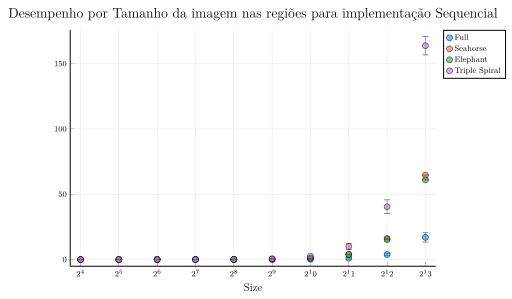

In [142]:
plot_results(seq_full.size, seq_full.mean_duration, "Full", seq_full.ci_duration,
    y2 = seq_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = seq_seahorse.ci_duration,
    y3 = seq_elephant.mean_duration, series_label3 = "Elephant", yerror3 = seq_elephant.ci_duration,
    y4 = seq_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = seq_triplespiral.ci_duration,
    title = "Desempenho por Tamanho da imagem nas regiões para implementação Sequencial",
    xaxis = "Size", max_thread_power = 13)

### OpenMP

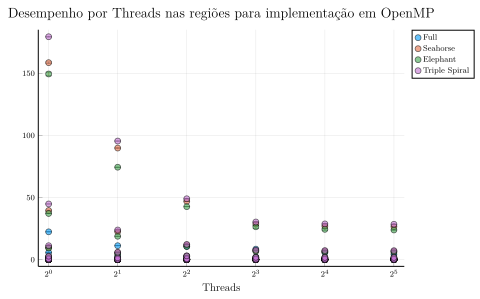

In [140]:
plot_results( omp_full.threads, omp_full.mean_duration, "Full", omp_full.ci_duration,
    y2 = omp_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = omp_seahorse.ci_duration,
    y3 = omp_elephant.mean_duration, series_label3 = "Elephant", yerror3 = omp_elephant.ci_duration,
    y4 = omp_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = omp_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em OpenMP")

### PThreads

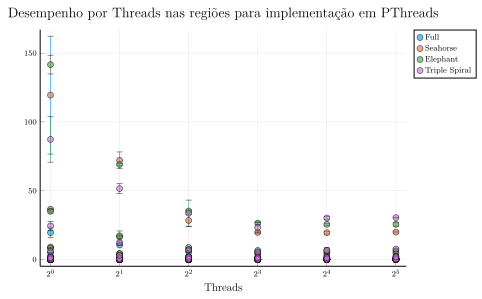

In [141]:
plot_results(pth_full.threads, pth_full.mean_duration, "Full", pth_full.ci_duration,
    y2 = pth_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = pth_seahorse.ci_duration,
    y3 = pth_elephant.mean_duration, series_label3 = "Elephant", yerror3 = pth_elephant.ci_duration,
    y4 = pth_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = pth_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em PThreads")

### OMPI

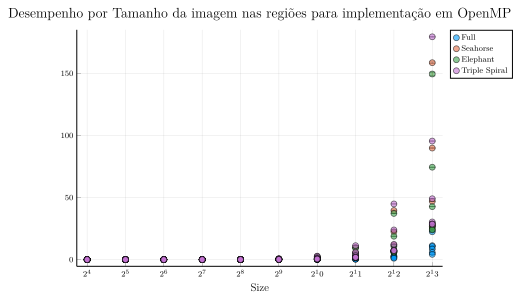

In [143]:
plot_results( omp_full.size, omp_full.mean_duration, "Full", omp_full.ci_duration,
    y2 = omp_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = omp_seahorse.ci_duration,
    y3 = omp_elephant.mean_duration, series_label3 = "Elephant", yerror3 = omp_elephant.ci_duration,
    y4 = omp_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = omp_triplespiral.ci_duration,
    title = "Desempenho por Tamanho da imagem nas regiões para implementação em OpenMP",
    xaxis = "Size", max_thread_power = 13)

### Cuda

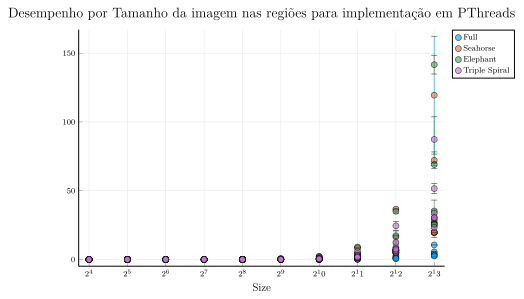

In [144]:
plot_results(pth_full.size, pth_full.mean_duration, "Full", pth_full.ci_duration,
    y2 = pth_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = pth_seahorse.ci_duration,
    y3 = pth_elephant.mean_duration, series_label3 = "Elephant", yerror3 = pth_elephant.ci_duration,
    y4 = pth_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = pth_triplespiral.ci_duration,
    title = "Desempenho por Tamanho da imagem nas regiões para implementação em PThreads",
    xaxis = "Size", max_thread_power = 13)

## Impacto do tempo de alocação de memória e I/O - Implementação Sequencial

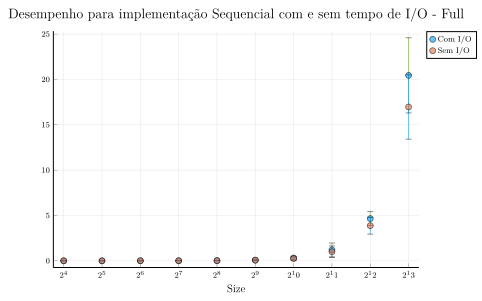

In [129]:
plot_results(seq_full.size, seq_full.mean_io_alocation, "Com I/O", seq_full.ci_io_alocation,
    y2 = seq_full.mean_duration, series_label2 = "Sem I/O", yerror2 = seq_full.ci_duration,
    title = "Desempenho para implementação Sequencial com e sem tempo de I/O - Full",
    xaxis = "Size", max_thread_power = 13)

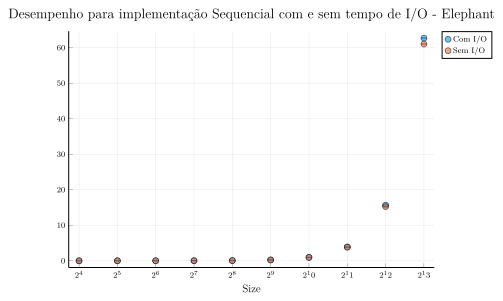

In [128]:
plot_results(seq_elephant.size, seq_elephant.mean_io_alocation, "Com I/O", seq_elephant.ci_io_alocation,
    y2 = seq_elephant.mean_duration, series_label2 = "Sem I/O", yerror2 = seq_elephant.ci_duration,
    title = "Desempenho para implementação Sequencial com e sem tempo de I/O - Elephant",
    xaxis = "Size", max_thread_power = 13)

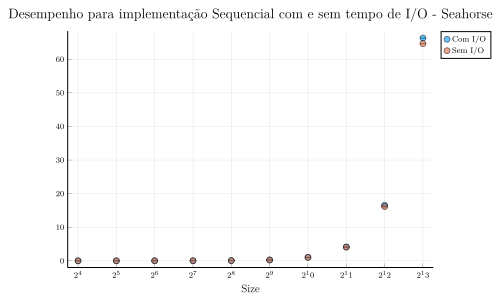

In [130]:
plot_results(seq_seahorse.size, seq_seahorse.mean_io_alocation, "Com I/O", seq_seahorse.ci_io_alocation,
    y2 = seq_seahorse.mean_duration, series_label2 = "Sem I/O", yerror2 = seq_seahorse.ci_duration,
    title = "Desempenho para implementação Sequencial com e sem tempo de I/O - Seahorse",
    xaxis = "Size", max_thread_power = 13)

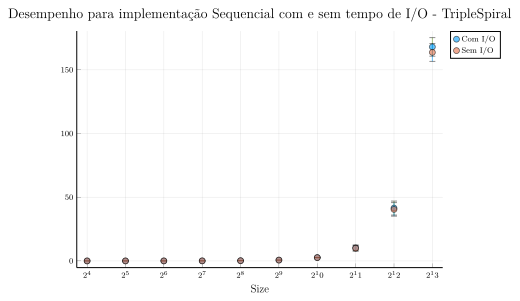

In [127]:
plot_results(seq_triplespiral.size, seq_triplespiral.mean_io_alocation,"Com I/O", 
    seq_triplespiral.ci_io_alocation, y2 = seq_triplespiral.mean_duration, 
    series_label2 = "Sem I/O", yerror2 = seq_triplespiral.ci_duration,
    title = "Desempenho para implementação Sequencial com e sem tempo de I/O - TripleSpiral",
    xaxis = "Size", max_thread_power = 13)

# Conclusões

`<<  em desenvolviemnto  >>`